
## DSM020 CW2 
### Shu Wang Lo
### September 2022

### Table of Contents
#### 1. Introduction 
#### 2. Data Exploration
#### 3. Energy Production Modeling
#### 4. Energy Consumption Modeling
#### 5. Model Testing
#### 6. Conclusion
#### 7. Reference Information
#### 8. Acknowledgements 

## 1. Introduction

Solar technology is not a new field. It has been in use since as far back as the 1970s, but only in the last few decades has it really taken off as an economically feasible energy source alternative for the consumer market. However, due to the intermittency of solar power, it is becoming a trend to integrate solar and energy storage into complete systems, as well as including data monitoring for making sure proper functioning of the systems. Q Cells is one of the major players in the solar technology space that constantly strives to improve its products and optimize its solar technology for average househould use. As a collaborative project, Q Cells has made available sample monitoring data over a a one year period from a home in San Diego, California. This data is time series based, including the power, current and voltage from the sensors in different parts of the system (e.g. inverter, battery, etc), as well as the solar radiance from the weather stations, etc. 

**The goals of this project proposal are to utilize the data sets to determine;**

<ol>
  <li>A quantitative model for predicting daily solar energy production</li>
  <li>A quantitative model for predicting the daily energy consumption of the home</li>
</ol>


### 1.1 Background

Before we dive into the data, it would be a good idea for us to have a basic understand of the major components and working parts in the solar panel kit that is marketed towards an average household. This combined system is known as a Photovoltaic System (PV System). 

The PV system consists of 2 solar arrays (e.g. solar panels), which are connected to an hybrid inverterter (an inverter that can convert DC to AC power or vice versa), a DC battery, home loads and finally to the power grid. The two solar arrays convert solar energy into DC power output. The battery charges from the DC power generated by the two solar arrays, or it can also charge from the DC power provided by the inverter which takes AC power from the grid. The hybrid inverter can convert DC power either from the solar arrays or during battery discharging to AC power for home load consumption and grid feed-in. In addition, the hybrid inverter can also take the AC power from the grid, convert it into DC power and charge the battery. The two solar arrays, however, can not take power from the inverter. 

The home loads are all AC power-based. They can only consume power but they cannot provide power. The grid can take power from the inverter if the home load cannot consume all of them. It can also provide power to the home load if the inverter cannot provide sufficient power. Furthermore, the grid can provide power to the inverter for charging the battery if the home load consumption is high and the two PV arrays are not producing enough DC power. 


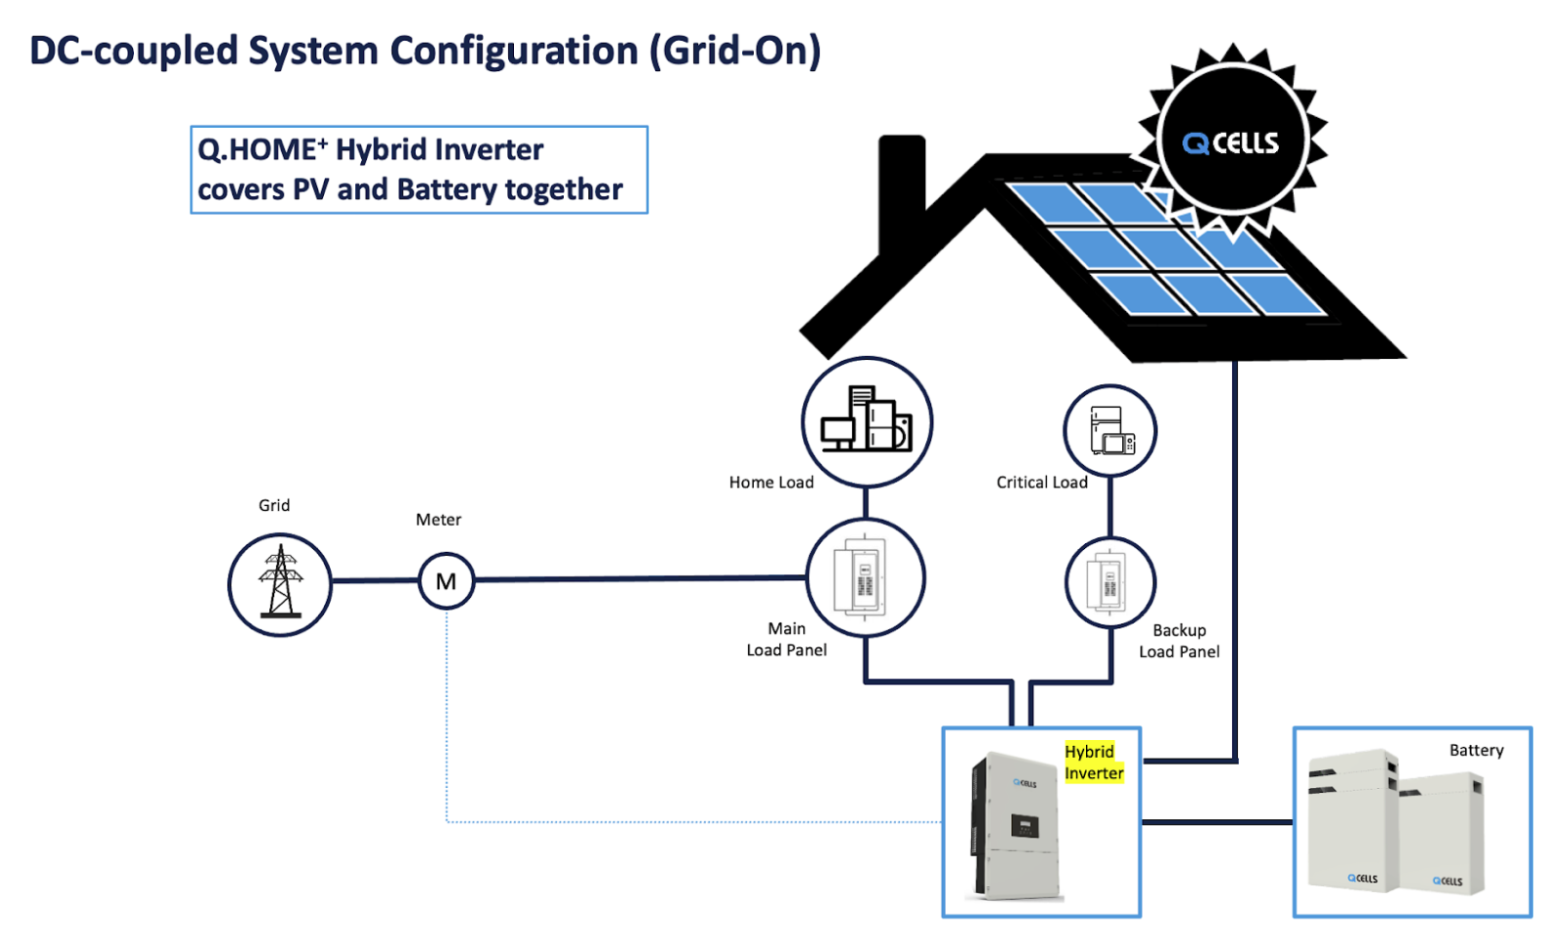

#### Graphic 1: DC-coupled System Configuration
This graphic displays the main components of the PV system. Note the solar array(s) represented by the blue solar panels on the graphic, as well as the inverter (highlighted) and how the system connects to the grid.  

### 1.3 The dataset 

In initial dataset, as received from Q Cells, was created using a combination of two existing data sets; system monitoring data from a specific home PV system located in San Diego, and San Diego's local weather data as obtained from Meteomatics.

The system data from the PV system includes a number of variables including power, current, voltage and other readouts for each individual solar array. The data is generally collected in 5 min averages. 

Some things to keep in mind regarding this system data:
 
- The inverter temperature (inverter_temperature below) is collected from the inverter, which means it is distinct from the global temperature data. 
- The energy production of the home is related to solar energy production only, i.e. not related to inverter, battery, home load or grid behaviors
- The energy consumption of the home is related to the inverter ac output and grid feed-in power only, i.e. not related to solar production or battery behaviors

The weather data was acquired from Mateomatics which provides the San Diego weather data, specifically the global radiance and temperature, but the data is for the entire city of San Diego.
    

### 1.4 Intial Data File

In this section we import the necessary packages and our dataset

In [1]:
# Import necessary packages

import math as m
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import abline_plot
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
# Import data from csv file

path = 'data.csv'
data = (pd
        .read_csv(path, parse_dates=['time', 'Pacific Time'])
        .set_index('time')
       )

In [3]:
# Get basic information about the dataset
# Change'UTC' timestamps to 'US/Pacific'
# Make the modified timestamps the index then drop the original column

pacific = data.index.tz_convert('US/Pacific')
data.reindex(pacific)
data.drop(columns='Pacific Time', inplace=True)

In [4]:
# Get table diagnostics before cleaning
# an explanation of the variables are given in Section 7 Reference

data.head().T
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105205 entries, 2021-07-01 00:00:00+00:00 to 2022-07-01 07:00:00+00:00
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SD_global_radiance    105205 non-null  float64
 1   SD_temperature        105205 non-null  float64
 2   idc1                  99212 non-null   float64
 3   idc2                  99212 non-null   float64
 4   vdc1                  99212 non-null   float64
 5   vdc2                  99212 non-null   float64
 6   acpower               99212 non-null   float64
 7   inverter_temperature  99212 non-null   float64
 8   feedinpower           99212 non-null   float64
 9   powerdc1              99212 non-null   float64
 10  powerdc2              99212 non-null   float64
 11  batPower              99212 non-null   float64
dtypes: float64(12)
memory usage: 14.5 MB


,SD_global_radiance,SD_temperature,idc1,idc2,vdc1,vdc2,acpower,inverter_temperature,feedinpower,powerdc1,powerdc2,batPower
count,105205.000000,105205.000000,99212.000000,99212.00000,99212.000000,99212.000000,99212.000000,99212.000000,99212.000000,99212.000000,99212.000000,99212.000000
mean,223.571971,20.153188,1.986111,2.44209,115.263161,117.671942,841.087681,19.219530,-13.230668,457.546718,485.700366,7.293624
std,303.274514,8.576883,3.138982,9.89200,121.347042,122.727602,1279.994520,78.391581,1276.687304,724.773691,753.984714,747.590954
min,0.000000,4.500000,0.000000,0.00000,0.000000,-2.800000,-961.000000,-3635.000000,-13106.000000,0.000000,0.000000,-2751.000000
25%,0.000000,13.600000,0.000000,0.00000,0.000000,0.000000,0.000000,15.000000,-468.000000,0.000000,0.000000,0.000000
50%,0.700000,18.500000,0.000000,0.00000,0.000000,0.000000,274.000000,19.000000,-68.000000,1.000000,2.000000,0.000000
75%,444.500000,25.800000,2.800000,3.10000,247.500000,248.900000,966.000000,25.000000,-8.000000,685.000000,762.000000,16.000000
max,1023.000000,43.400000,12.900000,301.00000,314.200000,312.100000,7066.000000,3771.000000,5922.000000,3361.000000,3327.000000,2770.000000


#### Table 1: Descriptions of initial data set before cleaning

## 2. Data Exploration

In this section we begin our exploration of the data and attempt to diagnose and fix any issues we find. 

In [5]:
# Check percentage of missing values in the dataset

missing = data.isnull().sum()/len(data)*100
missing

SD_global_radiance      0.000000
SD_temperature          0.000000
idc1                    5.696497
idc2                    5.696497
vdc1                    5.696497
vdc2                    5.696497
acpower                 5.696497
inverter_temperature    5.696497
feedinpower             5.696497
powerdc1                5.696497
powerdc2                5.696497
batPower                5.696497
dtype: float64

#### Table 2: Percentage of Missing Data by variable

The percentage of missing data is in the range of 5-6%. In an ideal situation we would attempt to replace this missing data through two different methods:

<ol>
  <li>Instances where only a few consecutive rows of data are missing should be replaced by averaging the proceeding and later data. </li>
  <li>Instances where there are many consecutive rows of missing data indicate a significant equipment issue and should be removed entirely. e.g. instances where several days worth of rows of data are missing</li>
</ol>

For this proposal, we have chosen to omit all the missing data entirely and declined to replace it using either method. Since the percentage of data missing is quite small, this should not have any significant adverse effects on the final models produced. 

In [6]:
# Duplicate the dataset to preserve it before any major changes are made
# DataC is now a working dataset
# Check the percentage of missing values

dataC = data

The next step is essentially a 'sanity check' to ensure that the data makes sense from an equipment specification perspective. Readings that fall out of the allowed specification range for specific pieces of equipment are omitted because they simply don't make sense. The exact specifications are based on provided product specs and system design documents. 


In [7]:
# Remove values that are out of the allowed specification range
# the range of the values of each varion was provided by the Q Cells team

# SD_global_radiance and SD_temperature are assumed to be accurate

# idc1 and idc2 must be between 0 and 13 A
dataC['idc1'] = np.where(dataC['idc1'] > 13, np.NaN, dataC['idc1'])
dataC['idc2'] = np.where(dataC['idc2'] > 13, np.NaN, dataC['idc2'])

# vdc1 and vdc2 must be between 0 and 400 V
dataC['vdc1'] = np.where(dataC['vdc1'] > 400, np.NaN, dataC['vdc1'])
dataC['vdc2'] = np.where(dataC['vdc2'] > 400, np.NaN, dataC['vdc2'])

# acpower must be between -8360W and 8360 W (no adjustment required)
dataC['acpower'] = np.where(dataC['acpower'] < -8360, np.NaN, dataC['acpower'])

# inverter_temperature must be between -20 C and 60 C 
dataC['inverter_temperature'] = np.where(dataC['inverter_temperature'] < -20, np.NaN, dataC['inverter_temperature'])
dataC['inverter_temperature'] = np.where(dataC['inverter_temperature'] > 60, np.NaN, dataC['inverter_temperature'])

# powerdc1 and powerdc2 must be between 0 and 7200 W (no adjustment required)
dataC['powerdc1'] = np.where(dataC['powerdc1'] < 0, np.NaN, dataC['powerdc1'])
dataC['powerdc1'] = np.where(dataC['powerdc1'] > 7200, np.NaN, dataC['powerdc1'])
dataC['powerdc2'] = np.where(dataC['powerdc2'] < 0, np.NaN, dataC['powerdc2'])
dataC['powerdc2'] = np.where(dataC['powerdc2'] > 7200, np.NaN, dataC['powerdc2'])

# batPower must be between -2510 and 2825 W 
dataC['batPower'] = np.where(dataC['batPower'] < -2510, np.NaN, dataC['batPower'])
dataC['batPower'] = np.where(dataC['batPower'] > 2825, np.NaN, dataC['batPower'])

In [8]:
#Perform a correlation test 

correlation = pd.DataFrame(dataC.corr())
correlation

,SD_global_radiance,SD_temperature,idc1,idc2,vdc1,vdc2,acpower,inverter_temperature,feedinpower,powerdc1,powerdc2,batPower
SD_global_radiance,1.000000,0.873148,0.907914,0.917699,0.751850,0.750539,0.834188,0.736767,0.676733,0.908223,0.919876,0.314056
SD_temperature,0.873148,1.000000,0.779442,0.785513,0.686660,0.683415,0.755185,0.884665,0.499708,0.783267,0.787074,0.207292
idc1,0.907914,0.779442,1.000000,0.973731,0.616232,0.627749,0.831150,0.631598,0.714795,0.985235,0.969917,0.439306
idc2,0.917699,0.785513,0.973731,1.000000,0.638733,0.634425,0.827031,0.625043,0.713038,0.966460,0.992019,0.453309
vdc1,0.751850,0.686660,0.616232,0.638733,1.000000,0.971427,0.551647,0.574174,0.438417,0.642770,0.649246,0.282474
vdc2,0.750539,0.683415,0.627749,0.634425,0.971427,1.000000,0.551256,0.585093,0.432569,0.637777,0.652862,0.285296
acpower,0.834188,0.755185,0.831150,0.827031,0.551647,0.551256,1.000000,0.670073,0.717764,0.854569,0.842875,-0.072975
inverter_temperature,0.736767,0.884665,0.631598,0.625043,0.574174,0.585093,0.670073,1.000000,0.411736,0.633145,0.632551,0.068190
feedinpower,0.676733,0.499708,0.714795,0.713038,0.438417,0.432569,0.717764,0.411736,1.000000,0.733042,0.724190,0.140733
powerdc1,0.908223,0.783267,0.985235,0.966460,0.642770,0.637777,0.854569,0.633145,0.733042,1.000000,0.973099,0.416525


#### Table 3: Correlation Test Results Between the Variables in Initial Dataset 

When we proceed with the analysis powerdc1 and powerdc2 will be used for calculating the daily energy production by the two solar arrays. As expected, powerdc1 and powerdc2 are both closely related to idc1 and idc2, the dc currents of solar arrays 1 and 2. Also as we expect, powerdc1 and powerdc2 are closely related between themselves, since they are two arrays on the same site. E.g. two solar arrays sitting in close physical proximity. 

We also see that idc1 and idc2 in turn are closely related to SD_global_radiance, since solar panels converts sun light into electricity. Consequently, powerdc1 and powerdc2 are also highly correlated with SD_global_radiance. powerdc1 and powerdc2 are not related to batPower (power of the battery), or feedinpower (power from the grid)

Finally the acpower (inverter output power) depends on powerdc1 and powerdc2, since it converts dc power from the solar arrays into ac power, but since solar panels are uni-directional devices, i.e. cannot take power from inverters, there is no need to analyze the solar energy production dependence on acpower

A better understanding of the behaviors of idc1, idc2, powerdc1, powerdc2 and SD_global_radiance is needed before modelling the daily energy production of the solar arrays

<AxesSubplot:>

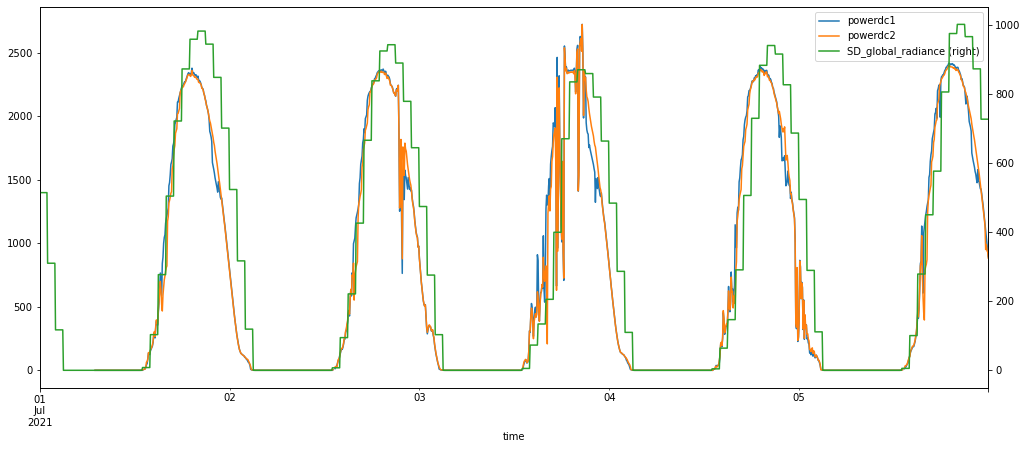

In [9]:
# To better understand the behaviors of the variables, we graph powerdc1, powerdc2 and SD_global_rdiance over a week. 

ax = dataC.loc['2021-7-01':'2021-7-05', ['powerdc1', 'powerdc2']].plot(figsize=(17,7))
dataC.loc['2021-7-01':'2021-7-05', ['SD_global_radiance']].plot(figsize=(17,7), secondary_y=True, ax=ax)

#### Figure 1: idc1 and idc2 from 7/1 - 7/5 


From the chart we can see that powerdc1 and powerdc2, power production of array 1 and array 2, follows the global radiace closely every morning. This makes sense as power production by the solar arrays 1 and 2 are supposed to be directly proportional to the global radiance. 

However in the afternoon, the solar power production is lower than the global radiance and the peaks do not match. There are several potential explanations for this: 

<ol>
  <li>the solar arrays have non-optimum orientations so that the maximum power production peak is shifted </li>
  <li>the global radiance detector is far away from the home, so that that the golbal irradiance measured is different from the irradiance at the home</li>
  <li>the temperature in the after is higher, which reduces the power production ability of the solar arrays</li>
</ol>

additionally, the power production curves of the solar arrays are not smooth, especially on July 4 which could have been brought about by various environmental conditions e.g. a cloudy sky or rain

<AxesSubplot:>

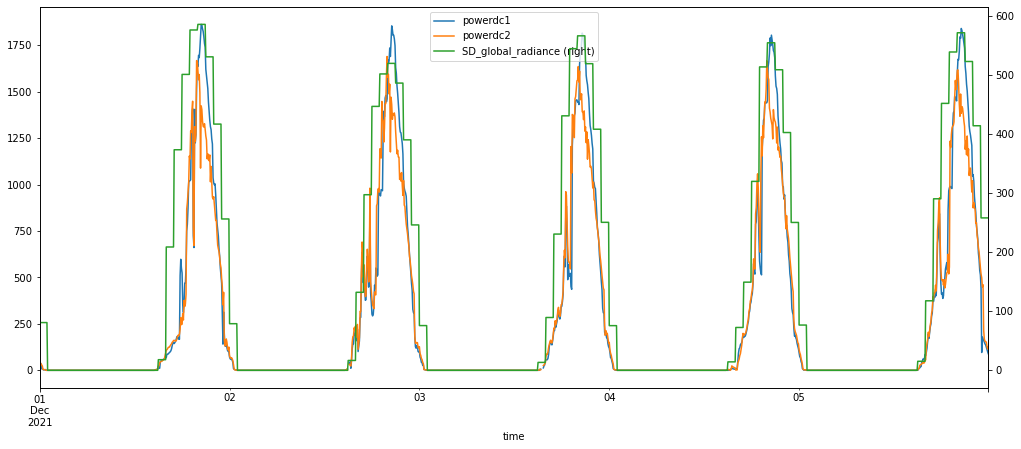

In [10]:
# We repeat the same process with data from a different time interval

ax = dataC.loc['2021-12-01':'2021-12-05', ['powerdc1', 'powerdc2']].plot(figsize=(17,7))
dataC.loc['2021-12-01':'2021-12-05', ['SD_global_radiance']].plot(figsize=(17,7), secondary_y=True, ax=ax)

#### Figure 2: idc1 and idc2 from 12/1 - 12/5 

As we can see when comparing Figure 1 and Figure 2, general patterns of global radiance and power production of solar arrays 1 and 2 are similar to July, but the power values are lower and the curves are noisier. This is likely because weather is generally less sunny in December. 

We can therefore conclude that power production of solar arrays 1 and 2 closely related to global irradiance but also strongly affected by outside variables due to weather like cloud cover. 

<AxesSubplot:title={'center':'idc1 vs SD Global Radiance'}, xlabel='Radiance (W/m^2)', ylabel='Solar Array 1 DC current (A)'>

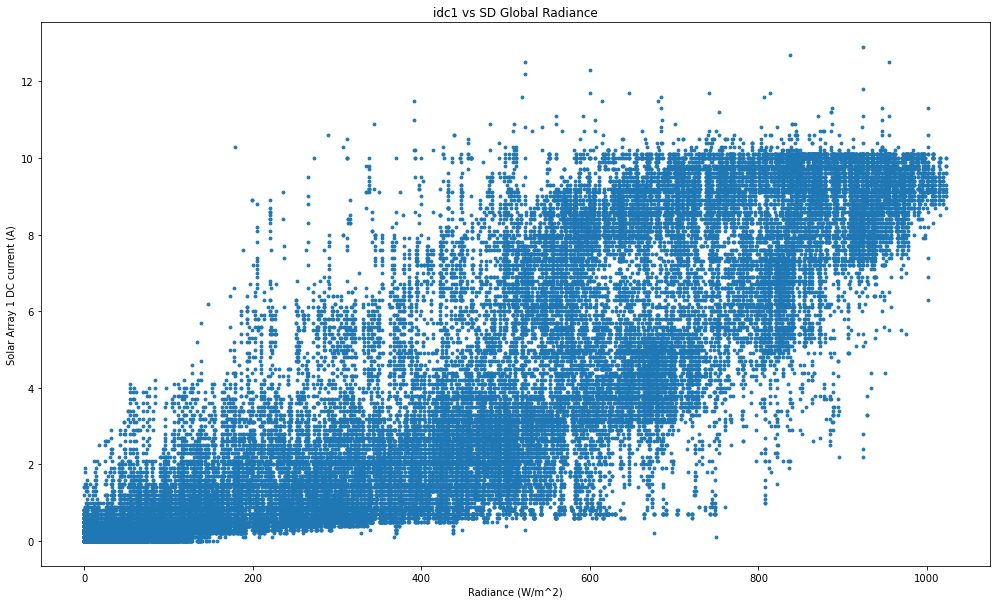

In [11]:
# We now attempt to visualize the relationship between idc1 and SD_global_radiance

dataC.plot( x = 'SD_global_radiance', 
            y = 'idc1', 
            kind = 'scatter',
            title = 'idc1 vs SD Global Radiance',
            xlabel = "Radiance (W/m^2)",
            ylabel = 'Solar Array 1 DC current (A)', 
            s = 8, 
            figsize=(17,10))

#### Figure 3: idc1 vs SD_global_radiance

Solar array current output and solar radians should be directly proportional. However this linear relationship is somewhat obscured. This can be because the solar radians is for the whole city of San Diego, which is a big city, or the radians sensor is far away from the solar array. 

<AxesSubplot:title={'center':'dc power to current ratio vs idc1'}, xlabel='Solar Array 1 DC current (A)', ylabel='dc power to current ratio of Solar Array 1'>

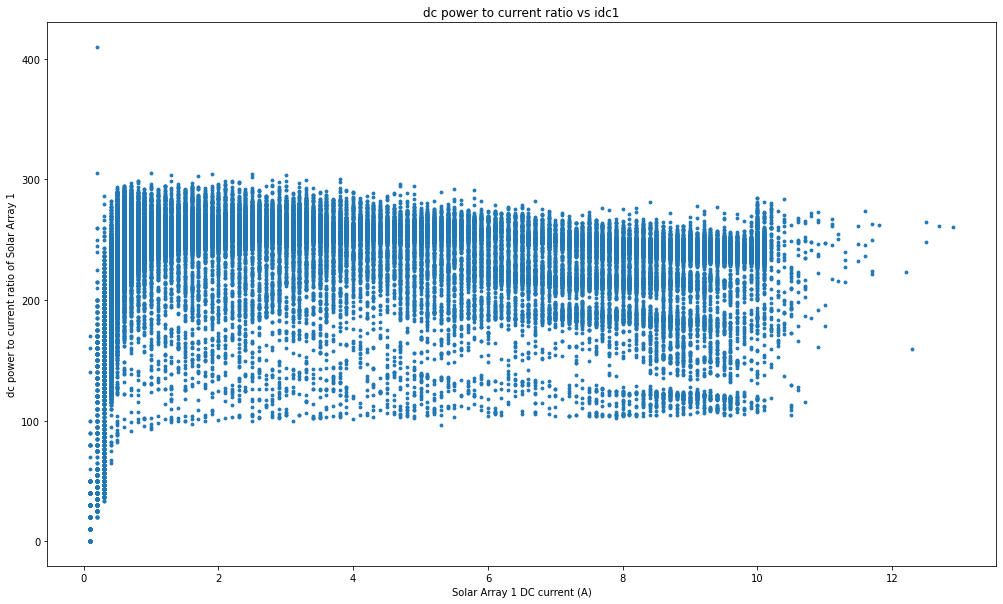

In [12]:
# Finally we attempt to demonstrate that there are faulty panels in Solar Array 1

# Define a new variable in dataC 'dc_power_to_current_ratio1'

dataC['dc_power_to_current_ratio1'] = dataC['powerdc1'] / dataC['idc1']

dataC.plot( x = 'idc1', 
            y = 'dc_power_to_current_ratio1', 
            kind = 'scatter',
            title = 'dc power to current ratio vs idc1',
            xlabel = "Solar Array 1 DC current (A)",
            ylabel = 'dc power to current ratio of Solar Array 1', 
            s = 8, 
            figsize=(17,10))

#### Figure 4: Plot to demonstrate that there are faulty panels in Solar Array 1

From solar panel device physics, dc_power_to_current_ratio1, i.e. voltage of solar array 1, should be a constant, as long as SD_global_radiance > 100W/m2. Plotting dc_power_to_current_ratio1 vs idc1 should hence be a horizontal straight line. However it can be seen from this plot that there are at least a few identifiable horizontal bands of data, in addition to other scattered data. 

On the other hand, the inverter needs a minimum vdc1 to start operating. This condition may not be always achievable through the days if the sky is cloudy. This in term leads to the solar array not operating in the optimized conditions as well.The scattered data and data bands are most likely due to sub-optimal operation conditions of the inverter,  resulting from cloudy skys.

## 3. Energy Production Modeling

In this section we attempt to build a model for energy production by examining the relationship between the energy production (powerdc) and the radiance produced by the sun (SD_global_radiance). 

### 3.1 solar arrays energy production and solar energy in 5 min intervals

In [13]:
# Derive and add two new parameters; powerdc, energydc_5 and solarenergy_5  

dataC['powerdc'] = dataC['powerdc1'] + dataC['powerdc2']
dataC['energydc_5'] = dataC['powerdc'] / (12*1000)
dataC['solarenergy_5'] = dataC['SD_global_radiance'] / (12*1000)

# powerdc is the total power generated by the two solar arrays 
# energydc_5 is the energy produced by the 2 solar arrays in 5 min
# solarenergy_5 is the energy delivered by the sun (SD_global_radiance) in 5 min

In [14]:
# Explore the correlation between the new variables and other variables. 

correlation = pd.DataFrame(dataC.corr())
correlation

,SD_global_radiance,SD_temperature,idc1,idc2,vdc1,vdc2,acpower,inverter_temperature,feedinpower,powerdc1,powerdc2,batPower,dc_power_to_current_ratio1,powerdc,energydc_5,solarenergy_5
SD_global_radiance,1.000000,0.873148,0.907914,0.917699,0.751850,0.750539,0.834188,0.736767,0.676733,0.908223,0.919876,0.314056,0.351257,0.920373,0.920373,1.000000
SD_temperature,0.873148,1.000000,0.779442,0.785513,0.686660,0.683415,0.755185,0.884665,0.499708,0.783267,0.787074,0.207292,0.278715,0.790541,0.790541,0.873148
idc1,0.907914,0.779442,1.000000,0.973731,0.616232,0.627749,0.831150,0.631598,0.714795,0.985235,0.969917,0.439306,0.198143,0.984063,0.984063,0.907914
idc2,0.917699,0.785513,0.973731,1.000000,0.638733,0.634425,0.827031,0.625043,0.713038,0.966460,0.992019,0.453309,0.240046,0.985469,0.985469,0.917699
vdc1,0.751850,0.686660,0.616232,0.638733,1.000000,0.971427,0.551647,0.574174,0.438417,0.642770,0.649246,0.282474,0.950106,0.650460,0.650460,0.751850
vdc2,0.750539,0.683415,0.627749,0.634425,0.971427,1.000000,0.551256,0.585093,0.432569,0.637777,0.652862,0.285296,0.730052,0.649852,0.649852,0.750539
acpower,0.834188,0.755185,0.831150,0.827031,0.551647,0.551256,1.000000,0.670073,0.717764,0.854569,0.842875,-0.072975,0.259942,0.854370,0.854370,0.834188
inverter_temperature,0.736767,0.884665,0.631598,0.625043,0.574174,0.585093,0.670073,1.000000,0.411736,0.633145,0.632551,0.068190,0.193835,0.636775,0.636775,0.736767
feedinpower,0.676733,0.499708,0.714795,0.713038,0.438417,0.432569,0.717764,0.411736,1.000000,0.733042,0.724190,0.140733,0.234346,0.733476,0.733476,0.676733
powerdc1,0.908223,0.783267,0.985235,0.966460,0.642770,0.637777,0.854569,0.633145,0.733042,1.000000,0.973099,0.416525,0.303481,0.992982,0.992982,0.908223


#### Table 4: Correlations between the new variables and previous variables

As we can see from the table, powerdc is closely related to powerdc1 and powerdc2, idc1 and idc2, as well as energydc_5. Similarly energydc_5 has the same correlations. In addition, solarenergy_5 is closely related to SD_global_radiance, idc1, idc2, powerdc1, powerdc2, energydc_5, powerdc since the solar panels convert the solar energy into those DC variables 


<AxesSubplot:title={'center':'powerdc vs SD temperature'}, xlabel='SD_temperature', ylabel='powerdc'>

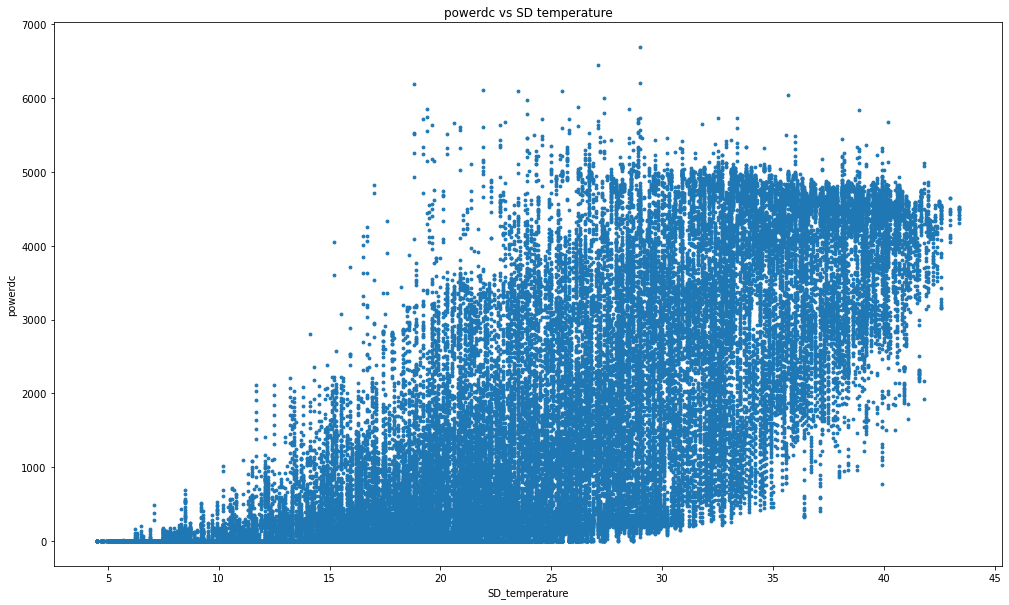

In [15]:
# We now try to visually examine the relationship between powerdc and SD_temperature

dataC.plot( x = 'SD_temperature', 
            y = 'powerdc', 
            kind = 'scatter',
            title = 'powerdc vs SD temperature',
            xlabel = 'SD_temperature',
            ylabel = 'powerdc', 
            s = 8, 
            figsize=(17,10))

#### Figure 5: powerdc vs SD temperature

The correlation coefficient between powerdc and SD_temperature in Table 4 is 0.791827, which is somewhat correlated but not perfect. This is reflected in the highly scattered plot between these two parameters in Figure 5. The highly scattered relationship can be ascribed to various possible reasons, including the difference in SD forecasted temperature and the solar array temperature, independent events such as inverter behavior.

<AxesSubplot:title={'center':'Energydc_5 vs. Solarenergy_5'}, xlabel='Solar energy in 5min', ylabel='Energy produced in 5min'>

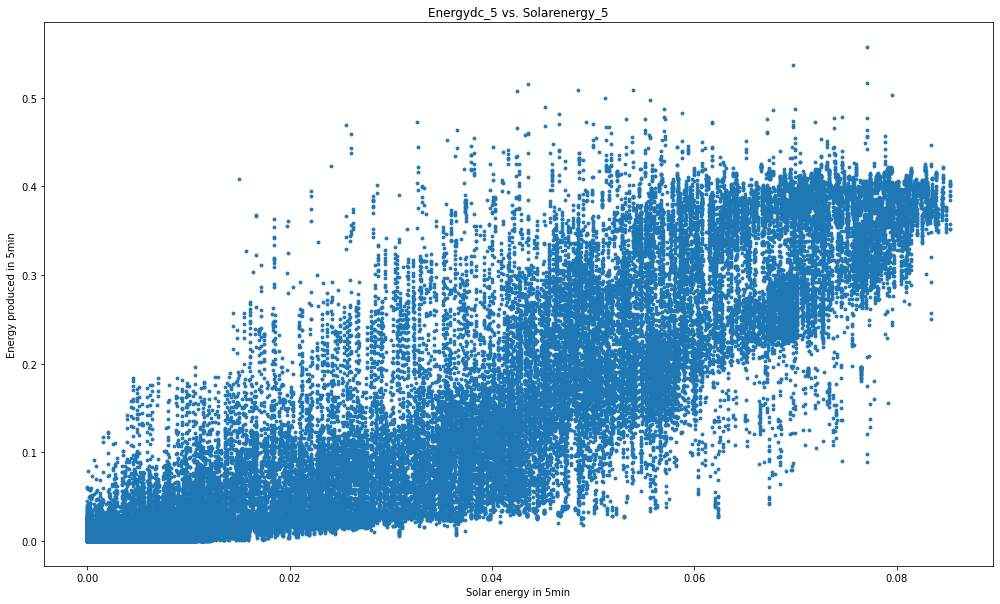

In [16]:
# Now we try to visually examine the relationship between energydc_5 and solarenergy_5

dataC.plot( x = 'solarenergy_5', 
            y = 'energydc_5', 
            kind = 'scatter',
            title = 'Energydc_5 vs. Solarenergy_5',
            xlabel = 'Solar energy in 5min',
            ylabel = 'Energy produced in 5min', 
            s = 8, 
            figsize=(17,10))

#### Figure 6: Energydc_5 vs. Solarenergy_5

Although the data in Figure 6 looks very scattered, there is a possible correlation between these two variables. This is consistent with the correlation coeffcient of 0.921189 in Table 4. The highly scattered nature of the data is probably related to the inverter behavior. For example the inveter requires a minimum input voltage to be activated. This means when the sunlight is low, the inverter will not start, although there is non-zero solar energy, which implies unstable correlation between these two parameters when sunlight is intermittent. 


### 3.2 solar arrays energy production and solar energy each day

In this section we begin aggregating the data from 5 min intervals into observations per day. 

The scatterness of the correlation between solarenergy_5 and energydc_5 will be reduced if both of them are integrated over time, i.e. the effects of solar intermittency can be cancelled by taking the sum over a period of time.

To do so the daily dc energy production by the solar arrays is first calculated. The same variable names are used temporarily for storing the integrated data, i.e. solar energy and energydc. These will be renamed to reflect the integrated nature in the next cell. 


In [17]:
# Group data by year/month/date to display the solar energy per day

SDenergy = pd.DataFrame(dataC.groupby([data.index.year, data.index.month, data.index.day]).sum())
SDenergy.index.names = ['Year', 'Month', 'Day']
SDenergy.columns

Index(['SD_global_radiance', 'SD_temperature', 'idc1', 'idc2', 'vdc1', 'vdc2',
       'acpower', 'inverter_temperature', 'feedinpower', 'powerdc1',
       'powerdc2', 'batPower', 'dc_power_to_current_ratio1', 'powerdc',
       'energydc_5', 'solarenergy_5'],
      dtype='object')

In [18]:
SDenergy.rename(columns={'solarenergy_5': 'solarenergy'}, inplace=True)
SDenergy.rename(columns={'energydc_5': 'energydc'}, inplace=True)

# solarenergy is the energy delivered by the sun in one day, and renamed after summation from solarenergy_5
# energydc is the energy produced by the 2 solar arrays in one day, and renamed after summation from energydc_5

<AxesSubplot:title={'center':'Daily Energy Production vs. Insolation kWh'}, xlabel='Insolation (kwh)', ylabel='Daily Energy Production (kwh)'>

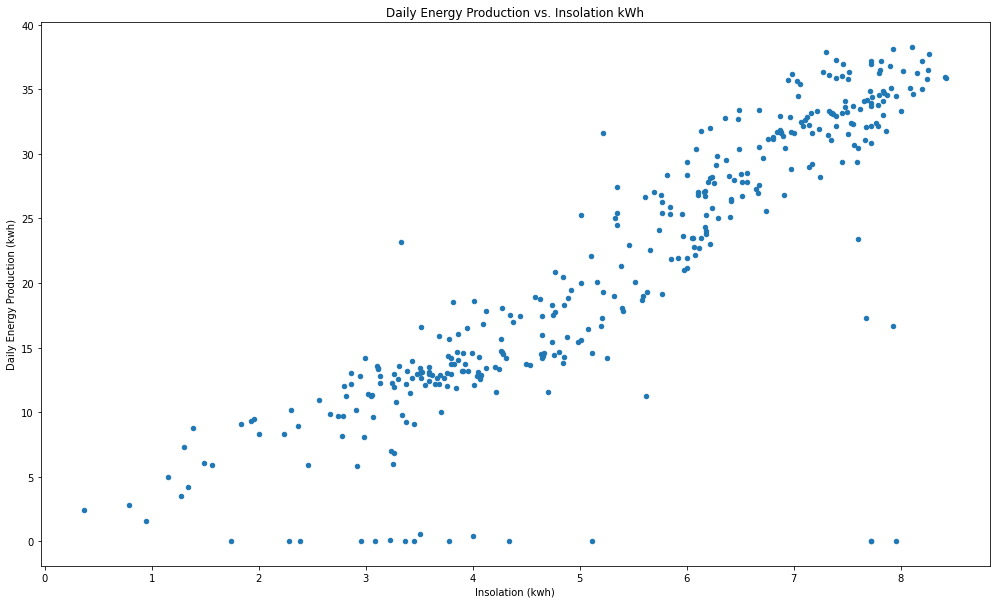

In [19]:
# After the changes above, we now graph energydc vs solarenergy 

SDenergy.plot( x = 'solarenergy', 
            y = 'energydc', 
            kind = 'scatter',
            title = 'Daily Energy Production vs. Insolation kWh',
            xlabel = 'Insolation (kwh)',
            ylabel = 'Daily Energy Production (kwh)', 
            s = 20, 
            figsize=(17,10))

#### Figure 7:  energydc vs solarenergy 

The scatterplot in figure 7 shows clearly the highly scattered nature found in Figure 6 has now been highly reduced. This is expected since, as said above, the effects of solar intermittency can be reduced by integration. On the other hand these two variables showed clear linear relationship, which is also expected from the high correlation coefficient in Table 4 and the scatterplot in Figure 6. 


In [20]:
# Run an OLS fit to create a model of the relationship between solarenergy and energydc

predictors = ['solarenergy']
outcome = 'energydc'

model = sm.OLS(SDenergy[outcome], SDenergy[predictors].assign(const=1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               energydc   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     1247.
Date:                Sun, 11 Sep 2022   Prob (F-statistic):          1.32e-119
Time:                        17:56:39   Log-Likelihood:                -1104.4
No. Observations:                 366   AIC:                             2213.
Df Residuals:                     364   BIC:                             2221.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
solarenergy     4.9198      0.139     35.308      0.000       4.646       5.194
const          -5.0400      0.790     -6.380      0.000      -6.593      -3.487
==============================================================================
Omnibus:                      285.149   Durbin-Watson:                   0.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5005.295
Skew:                          -3.156   Prob(JB):                         0.00
Kurtosis:                      19.982   Cond. No.                         17.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficients all have very low P values and reasonably high t values, showing that these coefficients are relevant. The negative nature of the first term, constant, is based on the fact that the inverter requires a minimum input voltage to be activated. In other words, if the solar energy is below a certain value there will be no dc energy output. The coefficient of the second term is related to the efficiency of the solar panels, i.e. the ability to convert solar energy into dc energy and is therefore a positive number. Finally the adjusted R^2 of the regression is 0.780, which is respectable but lower than expectation judging from the linear relationship in Table 4 and Figure 7.  


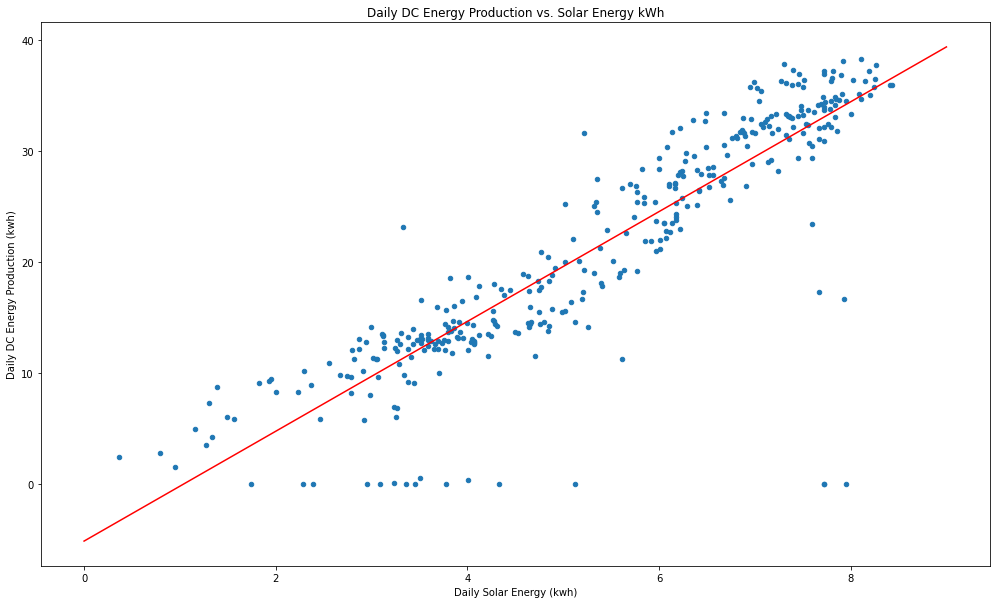

In [21]:
# We now re-do the graph in Figure 7 but now with the best fit line generated above. 

SDenergy.plot( x = 'solarenergy', 
            y = 'energydc', 
            kind = 'scatter',
            title = 'Daily DC Energy Production vs. Solar Energy kWh',
            xlabel = 'Daily Solar Energy (kwh)',
            ylabel = 'Daily DC Energy Production (kwh)', 
            s = 20, 
            figsize=(17,10))

x = np.array(range(10))
y = 4.9465*x + (-5.1431)
plt.plot(x,y, color = 'red')
plt.show()

#### Figure 8:  energydc vs solarenergy with best fit line

The best fit line is added to the scatterplot between solarenergy and energydc. As can be seen in this plot there are quite a few data points where the energydc is zero but solarenergy is scattered along the x axis. These are outliers that might have impact on the R^2 value of the regression.To filter out the effect of these outliers, it is necessary to locate them and remove them from the data set. 

To do this we will define a new variable; daily_energy_yield. daily_energy_yield is the normalized dc energy production according to the solar energy on the same day. It can be used for identifying the outliers where solarenergy is high but energydc is zero. 

In [22]:
# Define a new variable; daily_energy_yield

SDenergy['daily_energy_yield'] = SDenergy['energydc'] / SDenergy['solarenergy']

<AxesSubplot:>

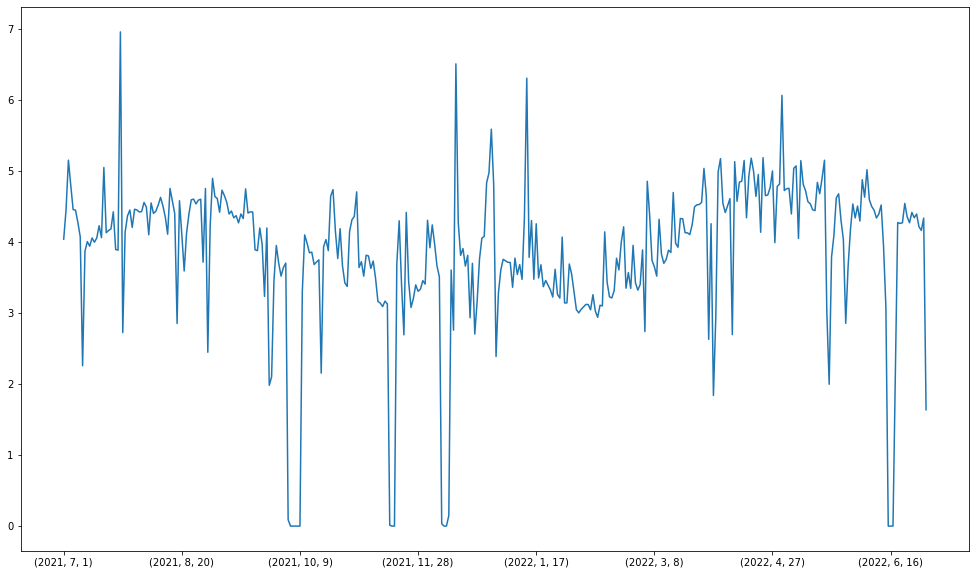

In [23]:
# We now chart the newly defined variable; Daily Energy Yield vs time

(SDenergy['daily_energy_yield']
 .groupby(SDenergy.index)
 .sum()
 .plot(figsize=(17,10)))

#### Figure 9: Daily Energy Yield vs time

The daily energy yield fluctuates between zero to 7 as can be seen in figure 9, these zero daily_energy_yield occurs in consecutive days, most likely due to failure of system communications, i.e. the wifi in the house was not working. Therefore a filtering of these data points can be conducted by rejecting daily_energy_yield that is lower than a threshold. The rejection threshold in this study is defined as 0.1, which is a very low yield number. 


In [24]:
# Fitering out daily_energy_yield data points

# Duplicate dataCD to create a copy where we:
# Remove any nan values from dataCD
# Also drop any values where daily_energy_yield is less than 0.1

dataCDa = SDenergy
dataCDa.dropna(how = 'all', inplace = True)
dataCDa.drop(dataCDa[dataCDa['daily_energy_yield'] < 0.1].index, inplace = True)

dataCDa

# there are now 351 data rows, i.e. 14 data rows had been dropped from the 1 year data set

SD_global_radiance  SD_temperature   idc1   idc2     vdc1  \
Year Month Day                                                              
2021 7     1               94352.4          7569.6  817.3  808.2  30716.9   
           2               88708.8          7455.6  844.9  836.0  38892.4   
           3               76321.2          7291.2  838.9  823.6  39487.3   
           4               82492.8          7396.8  834.6  839.4  39044.4   
           5               91858.8          7492.8  875.8  864.2  38421.2   
...                            ...             ...    ...    ...      ...   
2022 6     27              92694.0          7461.6  855.3  865.3  39737.9   
           28              94022.4          7766.4  839.7  845.1  38602.9   
           29              96039.6          7716.0  846.0  854.3  38754.6   
           30              93450.0          7747.2  847.8  857.1  39476.7   
     7     1               11331.6          2043.3   39.3   39.4   8536.7   

                   vdc2   acpower  inverter_temperature  feedinpower  \
Year Month Day                                                         
2021 7     1    30814.4  302634.0                4984.0     -59634.0   
           2    39086.2  367128.0                7006.0      16835.0   
           3    40251.5  354432.0                7063.0      78788.0   
           4    38882.4  362912.0                6933.0      75126.0   
           5    39377.2  373315.0                6931.0      97298.0   
...                 ...       ...                   ...          ...   
2022 6     27   40332.7  411203.0                7506.0    -248267.0   
           28   39512.9  363047.0                8064.0    -402048.0   
           29   39182.9  363671.0                8110.0    -347021.0   
           30   39769.5  373731.0                7670.0    -245081.0   
     7     1     8955.3   21050.0                2336.0    -169778.0   

                powerdc1  powerdc2  batPower  dc_power_to_current_ratio1  \
Year Month Day                                                             
2021 7     1    192165.0  188997.0   54951.0                         NaN   
           2    198766.0  196446.0    1459.0                         NaN   
           3    196879.0  196373.0   10988.0                         NaN   
           4    198234.0  197289.0   14654.0                         NaN   
           5    205946.0  203402.0   10211.0                         NaN   
...                  ...       ...       ...                         ...   
2022 6     27   202433.0  204877.0  -24263.0                         NaN   
           28   197564.0  198684.0    7340.0                         NaN   
           29   198751.0  201083.0    7020.0                         NaN   
           30   201389.0  203906.0   13593.0                         NaN   
     7     1      9310.0    9260.0   -6851.0                         NaN   

                 powerdc   energydc  solarenergy  daily_energy_yield  
Year Month Day                                                        
2021 7     1    381162.0  31.763500       7.8627            4.039770  
           2    395212.0  32.934333       7.3924            4.455161  
           3    393252.0  32.771000       6.3601            5.152592  
           4    395523.0  32.960250       6.8744            4.794637  
           5    409348.0  34.112333       7.6549            4.456274  
...                  ...        ...          ...                 ...  
2022 6     27   407310.0  33.942500       7.7245            4.394136  
           28   396248.0  33.020667       7.8352            4.214400  
           29   399834.0  33.319500       8.0033            4.163220  
           30   405295.0  33.774583       7.7875            4.337025  
     7     1     18570.0   1.547500       0.9443            1.638780  

[351 rows x 17 columns]

In [25]:
# Run an OLS fit to create a model of the relationship between solarenergy and energydc

predictors = ['solarenergy']
outcome = 'energydc'

# model = sm.OLS([outcome], dataCDa[predictors].assign(const=1))

model = sm.OLS(dataCDa[outcome], dataCDa[predictors].assign(const=1))
# Adj. R-squared:	0.780 to 0.893, which is a great improvement

model = sm.OLS(SDenergy[outcome], dataCDa[predictors].assign(const=1))
results = model.fit()
results.summary()

# this is the improved version of the regress and will be used for testing later

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               energydc   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     2702.
Date:                Sun, 11 Sep 2022   Prob (F-statistic):          2.22e-166
Time:                        17:56:40   Log-Likelihood:                -912.39
No. Observations:                 351   AIC:                             1829.
Df Residuals:                     349   BIC:                             1836.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
solarenergy     4.9242      0.095     51.980      0.000       4.738       5.111
const          -4.3959      0.541     -8.128      0.000      -5.460      -3.332
==============================================================================
Omnibus:                       81.904   Durbin-Watson:                   1.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              354.875
Skew:                          -0.922   Prob(JB):                     8.71e-78
Kurtosis:                       7.568   Cond. No.                         18.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

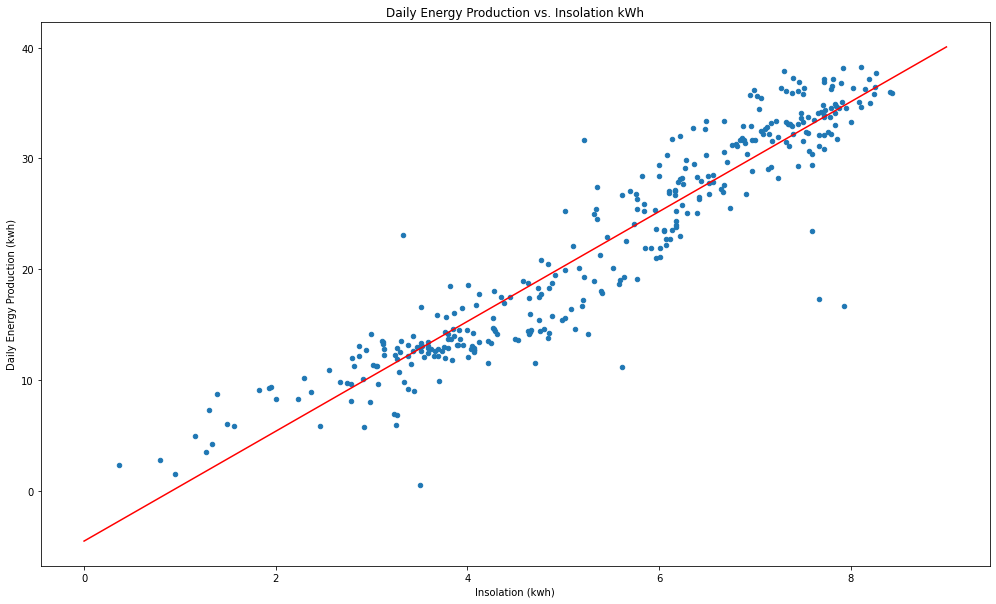

In [26]:
# We once again re-graph with the new best fit line included

SDenergy.plot( x = 'solarenergy', 
            y = 'energydc', 
            kind = 'scatter',
            title = 'Daily Energy Production vs. Insolation kWh',
            xlabel = 'Insolation (kwh)',
            ylabel = 'Daily Energy Production (kwh)', 
            s = 20, 
            figsize=(17,10))

x = np.array(range(10))
y = 4.9521*x + (-4.5049)
plt.plot(x,y, color = 'red')
plt.show()

#### Figure 10: Energydc vs. Solarenergy with best fit line


## 4. Energy Consumption Modeling

In this section we attempt to build a model for energy consumed by examining the relationship between power consumed and the temperature. 


### 4.1 Defining load energy per day

In [27]:
# Derive and add new parameters; loadpower 
# loadpower is the power consumed by the home loads 
# loadenergy_5 is the energy consumed by the home load in 5 min. 

dataC['loadpower'] = dataC['acpower'] - dataC['feedinpower']
dataC['loadenergy_5'] = dataC['loadpower'] / (12*1000)

dataC.describe()

,SD_global_radiance,SD_temperature,idc1,idc2,vdc1,vdc2,acpower,inverter_temperature,feedinpower,powerdc1,powerdc2,batPower,dc_power_to_current_ratio1,powerdc,energydc_5,solarenergy_5,loadpower,loadenergy_5
count,105205.000000,105205.000000,99212.000000,99042.000000,99212.000000,99212.000000,99212.000000,98951.000000,99212.000000,99212.000000,99212.000000,98497.000000,5.018500e+04,99212.000000,99212.000000,105205.000000,99212.000000,99212.000000
mean,223.571971,20.153188,1.986111,2.061747,115.263161,117.671942,841.087681,20.645865,-13.230668,457.546718,485.700366,26.248586,inf,943.247084,0.078604,0.018631,854.318349,0.071193
std,303.274514,8.576883,3.138982,3.203516,121.347042,122.727602,1279.994520,8.379557,1276.687304,724.773691,753.984714,716.285442,NaN,1468.783595,0.122399,0.025273,960.438931,0.080037
min,0.000000,4.500000,0.000000,0.000000,0.000000,-2.800000,-961.000000,-20.000000,-13106.000000,0.000000,0.000000,-2510.000000,0.000000e+00,0.000000,0.000000,0.000000,-2224.000000,-0.185333
25%,0.000000,13.600000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,-468.000000,0.000000,0.000000,0.000000,2.120000e+02,0.000000,0.000000,0.000000,340.000000,0.028333
50%,0.700000,18.500000,0.000000,0.000000,0.000000,0.000000,274.000000,19.000000,-68.000000,1.000000,2.000000,0.000000,2.416162e+02,4.000000,0.000333,0.000058,484.000000,0.040333
75%,444.500000,25.800000,2.800000,3.100000,247.500000,248.900000,966.000000,25.000000,-8.000000,685.000000,762.000000,16.000000,2.558065e+02,1458.000000,0.121500,0.037042,867.000000,0.072250
max,1023.000000,43.400000,12.900000,12.600000,314.200000,312.100000,7066.000000,47.000000,5922.000000,3361.000000,3327.000000,2770.000000,inf,6688.000000,0.557333,0.085250,13215.000000,1.101250


In [28]:
# Group data by year/month/date to display the load energy per day 
# Energy consumed by home load in one day is loadenergy (by renaming the summation of loadenergy_5)

loadenergy = pd.DataFrame(dataC.groupby([data.index.year, data.index.month, data.index.day]).sum())
loadenergy.index.names = ['Year', 'Month', 'Day']
dataCDb1 = loadenergy.loc[:, ['loadenergy_5']]
dataCDb1.rename({'loadenergy_5':'loadenergy'}, axis=1, inplace=True)

### 4.2 Defining maximum inverter and SD temperature per day

In [29]:
# Add a new variable; Tmax which is the max of inverter temperature per day
# Add a new variable; Tsdmax which is the max of San Diego temperature per day

Tmax = pd.DataFrame(dataC.groupby([data.index.year, data.index.month, data.index.day]).max())
Tmax.index.names = ['Year', 'Month', 'Day']
dataCDb2 = Tmax.loc[:, ['inverter_temperature', 'SD_temperature']]
dataCDb2.rename({'inverter_temperature':'Tmax', 'SD_temperature':'Tsdmax'}, axis=1, inplace=True)


In [30]:
# Concatenate the two new dataframes created above into a dataframe that includes all three new variables
# This new dataframe is needed for analyzing the relationship between loadenergy, Tmax and Tsdmax 

frames = [dataCDb1, dataCDb2]
dataCDb = pd.concat(frames, axis = 1)

dataCDb.describe()

,loadenergy,Tmax,Tsdmax
count,366.000000,354.000000,366.000000
mean,19.298413,35.177966,31.963934
std,11.821336,5.728955,6.772544
min,-0.135083,15.000000,15.000000
25%,11.978042,32.000000,27.125000
50%,15.112750,36.000000,32.600000
75%,23.707250,39.000000,38.200000
max,63.757917,47.000000,43.400000


<AxesSubplot:title={'center':'Tsdmax vs Tmax'}, xlabel='Tmax', ylabel='Tsdmax'>

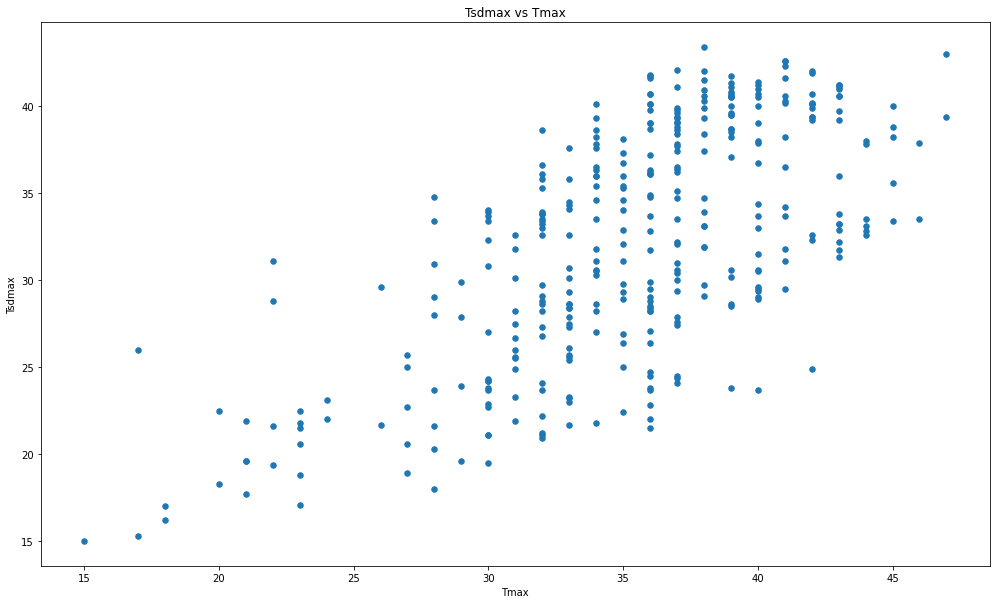

In [31]:
# We now plot Tsdmax vs Tmax

dataCDb.plot( x = 'Tmax', 
            y = 'Tsdmax', 
            kind = 'scatter',
            title = 'Tsdmax vs Tmax',
            xlabel = 'Tmax',
            ylabel = 'Tsdmax', 
            s = 30, 
            figsize=(17,10))

#### Figure 11: Tsdmax vs Tmax

The correlation between Tmax and Tsdmax is not strong, although there seems to be a correlation. The existence of a correlation between Tmax and Tsdmax is reasonable since the temperature of the inverter certainly depends on the temperature of San Diego, although it also depends on other variables like the air conditioning and the position of the inverter in the house. Tmax is more of a dependent variable on various parameters rather than a independent variable. 

<AxesSubplot:title={'center':'Loadenergy vs Tmax'}, xlabel='Tmax', ylabel='Loadenergy'>

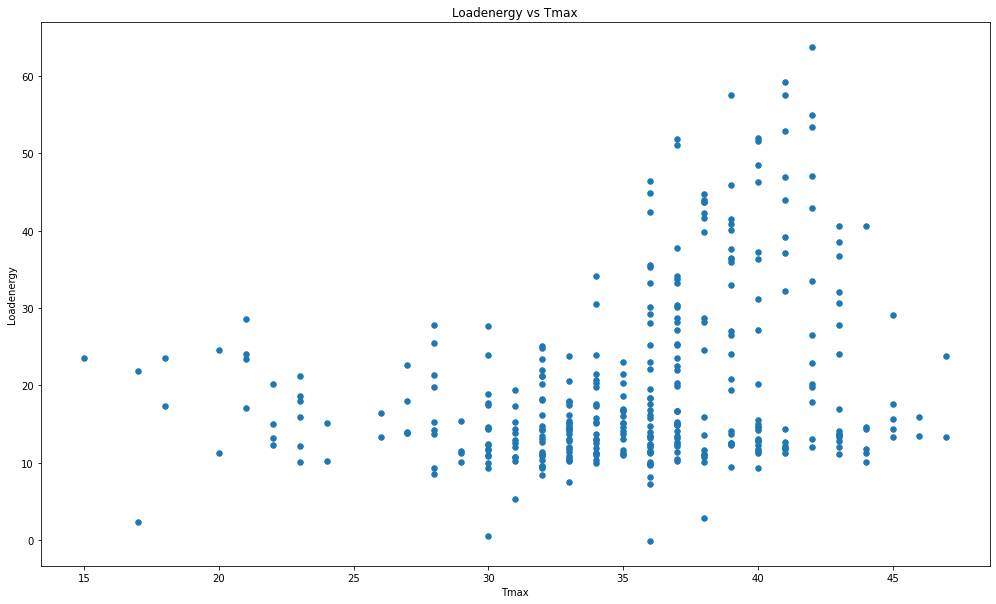

In [32]:
# We now graph Loadenergy vs Tmax

dataCDb.plot( x = 'Tmax', 
            y = 'loadenergy', 
            kind = 'scatter',
            title = 'Loadenergy vs Tmax',
            xlabel = 'Tmax',
            ylabel = 'Loadenergy', 
            s = 30, 
            figsize=(17,10))

#### Figure 12: Loadenergy vs Tmax

Similar to the dependence of Tmax on Tsdmax, the relationship between loadenergy and Tmax is not clear from Figure 12. Loadenergy certainly includes energy consumed by the air conditioning in the house, which in turn will affect Tmax. Consequently loadenergy and Tmax are highly convoluted. 

<AxesSubplot:title={'center':'Loadenergy vs Tsdmax'}, xlabel='Tsdmax', ylabel='Loadenergy'>

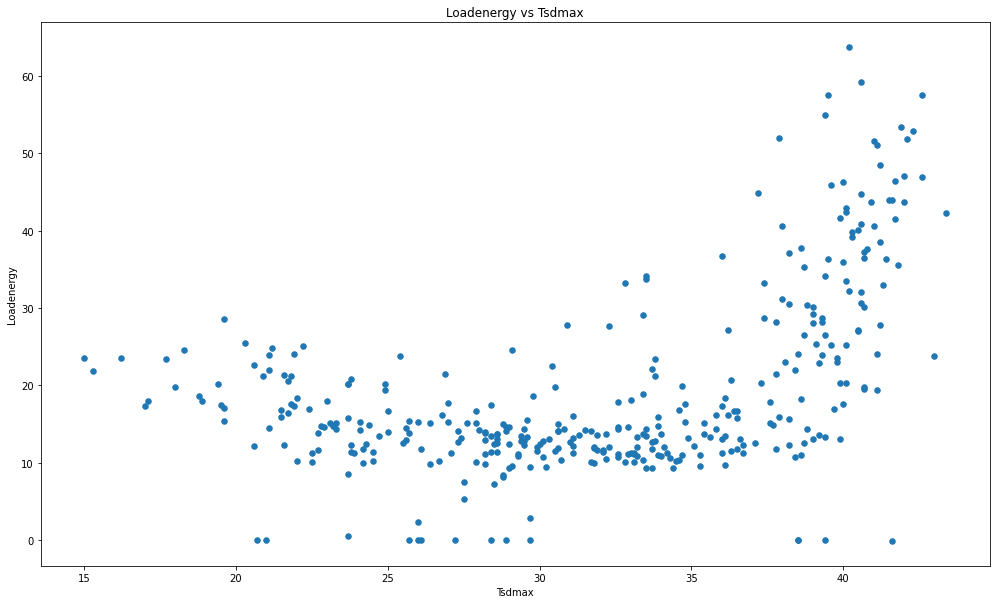

In [33]:
# We now graph Loadenergy vs Tsdmax

dataCDb.plot( x = 'Tsdmax', 
            y = 'loadenergy', 
            kind = 'scatter',
            title = 'Loadenergy vs Tsdmax',
            xlabel = 'Tsdmax',
            ylabel = 'Loadenergy', 
            s = 30, 
            figsize=(17,10))

#### Figure 13: Loadenergy vs Tsdmax

Although the relationship between loadenergy and Tsdmax is not linear, there is a clear relationship between these two variables. This is somewhat expected since Tsdmax is independent of house load consumption, or rather house load, such as air conditioning, is adjusted based on the temperature in its environment, i.e. Tsdmax. 

When Tsdmax is high, i.e. above 36 C, loadenergy increases rapidly with Tsdmax. This is possibly because air conditioning in the house starts operating at high power under high house temperature. On the other hand, loadenergy has weaker dependence on Tsdmax below 36C, perhaps due to the fact that air conditioning is not needed and low level heating may be necessary at temperatures as low as 15 C. It is clear that this relationship can not be modeled with linear regression. The non-linearity, however, can possibly be modeled with a power series. 

Also noticeable from the plot is that there are some outliers where loadenergy is zero whereas Tsdmax varies between 15 and 45 C. Based on the linear regression experience above, such outliers should be removed in order to develop accurate regression models.


### 4.3 Regression Modeling: Load energy vs Tsdmax

In [34]:
# Removal of outliers 
# Remove any nan values from DataCDb
# Also drop any values where daily_energy_yield is less than 0.1
# Also create an adjusted version of tsdmax 

dataCDb.dropna(how = 'all', inplace = True)
dataCDb.drop(dataCDb[dataCDb['loadenergy'] < 0.1].index, inplace = True)

In [35]:
# Run an OLS fit to create a model of the relationship between loadenergy and Tsdmax using a polynomial model

model_poly = ols(formula='loadenergy ~ Tsdmax + np.power(Tsdmax, 2) + np.power(Tsdmax, 3)  ', data=dataCDb)
result_poly = model_poly.fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:             loadenergy   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     164.5
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           1.90e-66
Time:                        17:56:42   Log-Likelihood:                -1204.8
No. Observations:                 353   AIC:                             2418.
Df Residuals:                     349   BIC:                             2433.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -34.8515    

We can see from the results that all the coefficients except the first term have close to zero P values, although the P value of the first term is not high either. This shows that the coefficients are valid. 

The R^2, on the other hand is only 0.594, which means only about 60% of the dependency between loadenergy can be explained by Tsdmax. This is not a highly accurate model, but considering the fact that temperature is only one of the factors affecting load consumption, i.e. air conditioning and heating, this model is respectable. Other factors, such as lighting, communcation devices, etc contribute to loadenergy consumption, but they are not part of the variables captured in the initial dataset. It can be anticipated that if those variables are also taken into account in this regression the R^2 can be higher than the current value. 

Attempts with higher powers, up to power 9, in the power series did not improve the validity of the coefficients and also R^2. The results are therefore not included here. 


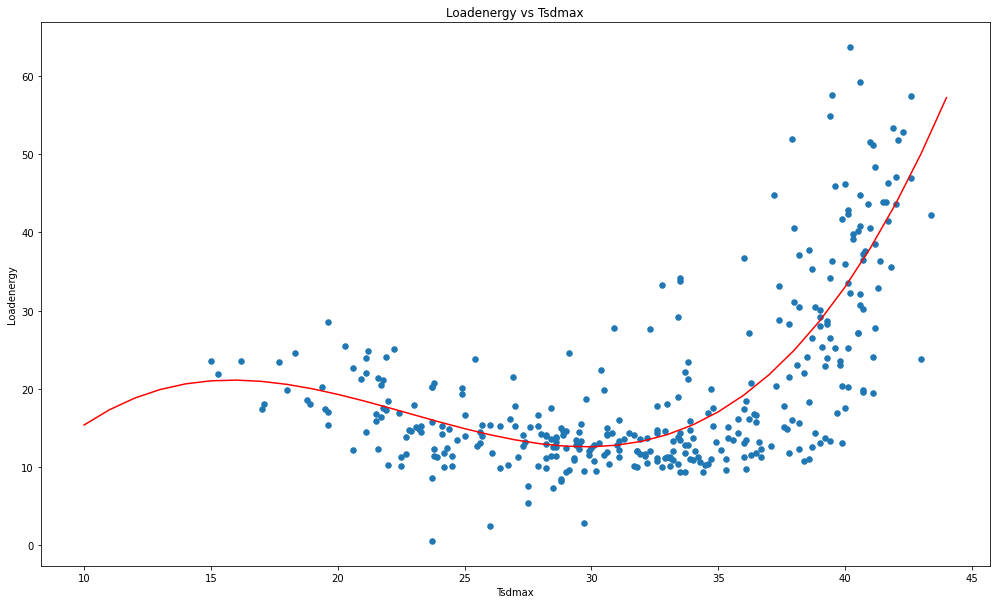

In [36]:
# We now re-graph loadenergy vs tsdmax data but this time with the resultant model generated earlier

dataCDb.plot( x = 'Tsdmax', 
            y = 'loadenergy', 
            kind = 'scatter',
            title = 'Loadenergy vs Tsdmax',
            xlabel = 'Tsdmax',
            ylabel = 'Loadenergy', 
            s = 30, 
            figsize=(17,10))

x = np.array(range(10, 45))
y =  0.0063*x**3 -0.4312*x**2 + 8.9186*x -37.0162
plt.plot(x,y, color = 'red')
plt.show()

#### Figure 14: Graph the resultant model on the loadenergy vs tsdmax data

Since the dataset was collected for Tsdmax between 14 and 45 C, any model outside this range is an extrapolation and therefore may not be accurate. 

This can be seen from the trend of the fitted line below 14 C. It shows a downward slope at lower temperatures which is impossible since at lower temperature there should be more heating in the house and therefore the trend should continue to go upwards instead. The P value of the first term in the model is therefore not as low as the other coefficients. 

Another approach to the modeling is a piecewise regression, i.e. dividing the data for Tsdmax higher than 36C and another data set lower than 36C. Then model these two data sets with seperate linear regressions. 

In [37]:
# As a first step to piecewise linear regression, create two new datasets for modeling
# Create two segments of dataCDb 
# Remove any nan values
# Also drop any values where daily_energy_yield is less than 0.1
# Segment into two parts; dataCDb1 where Tsdmax <= 36 and dataCDb2 where Tsdmax > 36

dataCDb1 = dataCDb.loc[(dataCDb['Tsdmax'] <= 36)]
dataCDb1.dropna(how = 'all', inplace = True)
dataCDb1.drop(dataCDb1[dataCDb1['loadenergy'] < 0.1].index, inplace = True)


/var/folders/dc/yclmmxqs4zdd3nghyrp02hq40000gn/T/ipykernel_28435/1952423671.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataCDb1.dropna(how = 'all', inplace = True)
/var/folders/dc/yclmmxqs4zdd3nghyrp02hq40000gn/T/ipykernel_28435/1952423671.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataCDb1.drop(dataCDb1[dataCDb1['loadenergy'] < 0.1].index, inplace = True)


In [38]:
# Create second segment of dataCDb 
# Remove any nan values
# Also drop any values where daily_energy_yield is less than 0.1
# Segment into two parts; data7a where Tsdmax > 36 and data7b where Tsdmax > 36

dataCDb2 = dataCDb.loc[(dataCDb['Tsdmax'] > 36)]
dataCDb2.dropna(how = 'all', inplace = True)
dataCDb2.drop(dataCDb2[dataCDb2['loadenergy'] < 0.1].index, inplace = True)


/var/folders/dc/yclmmxqs4zdd3nghyrp02hq40000gn/T/ipykernel_28435/2215550470.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataCDb2.dropna(how = 'all', inplace = True)
/var/folders/dc/yclmmxqs4zdd3nghyrp02hq40000gn/T/ipykernel_28435/2215550470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataCDb2.drop(dataCDb2[dataCDb2['loadenergy'] < 0.1].index, inplace = True)


In [39]:
# Run an OLS fit to create a model of dataCDb1

predictors = ['Tsdmax']
outcome = 'loadenergy'

model1 = sm.OLS(dataCDb1[outcome], dataCDb1[predictors].assign(const=1))
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             loadenergy   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     13.24
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           0.000337
Time:                        17:56:43   Log-Likelihood:                -710.13
No. Observations:                 233   AIC:                             1424.
Df Residuals:                     231   BIC:                             1431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Tsdmax        -0.2436      0.067     -3.639      0.000      -0.375      -0.112
const         21.7113      1.919     11.312      0.000      17.930      25.493
==============================================================================
Omnibus:                       81.411   Durbin-Watson:                   0.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.499
Skew:                           1.442   Prob(JB):                     1.23e-61
Kurtosis:                       7.536   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Although the P-values of the coefficients are close to zero which means they are relevant, the adjusted R^2 value is very low which means this model does not explain the relationship. This means the current linear regression model is not useful. 


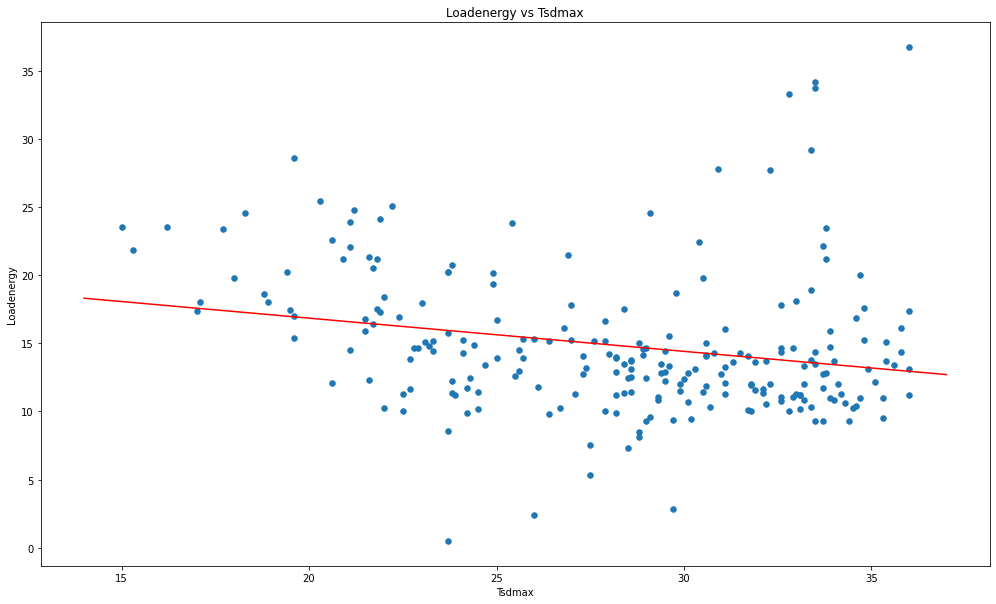

In [40]:
# Graph the resultant model against the data 

dataCDb1.plot( x = 'Tsdmax', 
            y = 'loadenergy', 
            kind = 'scatter',
            title = 'Loadenergy vs Tsdmax',
            xlabel = 'Tsdmax',
            ylabel = 'Loadenergy', 
            s = 30, 
            figsize=(17,10))

x = np.array(range(14, 38))
y = -0.2436*x + 21.7113
plt.plot(x,y, color = 'red')
plt.show()

#### Figure 15: Graph the resultant model against the data 


In [41]:
# Run an OLS fit to create a model of dataCDb2

predictors = ['Tsdmax']
outcome = 'loadenergy'

model2 = sm.OLS(dataCDb2[outcome], dataCDb2[predictors].assign(const=1))
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             loadenergy   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     69.75
Date:                Sun, 11 Sep 2022   Prob (F-statistic):           1.49e-13
Time:                        17:56:43   Log-Likelihood:                -452.92
No. Observations:                 120   AIC:                             909.8
Df Residuals:                     118   BIC:                             915.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Tsdmax         4.6469      0.556      8.352      0.000       3.545       5.749
const       -153.0528     21.947     -6.974      0.000    -196.514    -109.592
==============================================================================
Omnibus:                        5.686   Durbin-Watson:                   1.009
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                5.167
Skew:                           0.483   Prob(JB):                       0.0755
Kurtosis:                       3.314   Cond. No.                         893.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The P-values of the coefficients are all around zero meaning that they are relevant. The adjusted R^2 value is 0.382 which means only 38% of the loadenergy can be explained by Tsdmax. The model can not be described as being useful. 
The model to be used for testing is hence selected as the power series model.


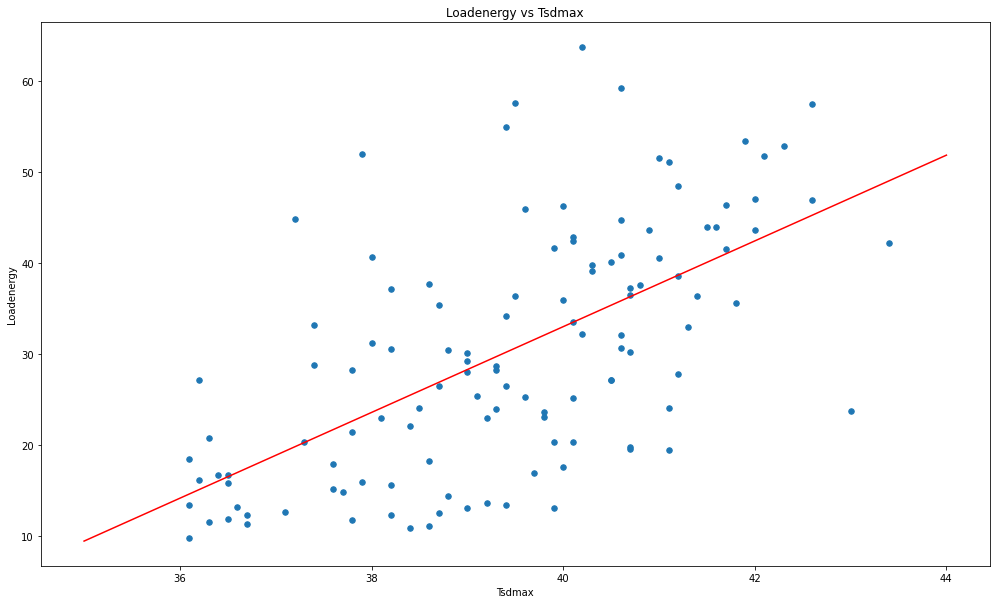

In [42]:
# Graph the resultant model against the data 

dataCDb2.plot( x = 'Tsdmax', 
            y = 'loadenergy', 
            kind = 'scatter',
            title = 'Loadenergy vs Tsdmax',
            xlabel = 'Tsdmax',
            ylabel = 'Loadenergy', 
            s = 30, 
            figsize=(17,10))

x = np.array(range(35, 45))
y = 4.7163*x + (-155.6636)
plt.plot(x,y, color = 'red')
plt.show()

#### Figure 16: Graph the resultant model against the data 


## 5. Model Testing

In this section we test the models that we generated in sections 3. and 4. 

### 5.1 Test Energy Production Model

In [43]:
# Create a test data set (dataCS_sum) by taking only the 1st and 15th day of each month and sorting the data by day

dataCS0 = dataCDa.loc[:, ['energydc', 'solarenergy']] 

# Need dt.datetime object for masking datetimeindex

import datetime as dt
first = dt.datetime(2021,7,1) # set a variable for 7/1/2021
fifthteen = dt.datetime(2021,7,15)  # set a variable for 7/15/2021
All = slice(None)  # set a variable for all data (i.e. no slicing)

dataCS1 = dataCS0.loc[All, All, fifthteen.day, :] 
dataCS2 = dataCS0.loc[All, All, first.day, :]

# concating the 2 dataframe.

frames = [dataCS1, dataCS2]
dataCS_sum = pd.concat(frames, axis = 0)

In [44]:
# To tet the energy production model we created 

dataCS_sum['energydc_EXP'] = dataCS_sum['solarenergy']* 4.9521 + (-4.5049)

In [45]:
# Calculate the RMSE between the forecast and the actual 'energydc' on the same dates

msProduction = mean_squared_error(dataCS_sum.energydc, dataCS_sum.energydc_EXP, squared=False)
rmsProduction = m.sqrt(msProduction)
rmsProduction

1.8190161557327562

### 5.2 Test Energy Consumption Model

In [46]:
# Create a second test data set (dataCS_max) by taking only the 1st and 15th day of each month and sorting the data by day

dataCS0_2 = dataCDb.loc[:, ['loadenergy', 'Tsdmax']] 

dataCS1_1 = dataCS0_2.loc[All, All, fifthteen.day, :] 
dataCS2_1 = dataCS0_2.loc[All, All, first.day, :]

# concating the 2 dataframe.

frames_1 = [dataCS1_1, dataCS2_1]
dataCS_max = pd.concat(frames_1, axis = 0)

In [47]:
# To test the energy consumption model we created in Section 3.3
# Create a new expected value column using the model we created

dataCS_max['loadenergy_EXP'] = 0.0063*dataCS_max['Tsdmax']**3 + (-0.4312)*dataCS_max['Tsdmax']**2 + 8.9186*dataCS_max['Tsdmax'] - 37.0162

In [48]:
# Calculate the RMSE between the forecast and the actual 'loadenergy' on the same dates

msConsumption = mean_squared_error(dataCS_max.loadenergy, dataCS_max.loadenergy_EXP, squared=False)
rmsConsumption = m.sqrt(msConsumption)
rmsConsumption

2.4307909201590556

### 5.3 Discussion on Model Accuracy
The linear regression model developed is a reasonably accurate and practical model.


####  Energydc vs solarenergy regression model accuracy

The RMSE between the expected energy production, energydc_EXP, and the acutal energy production, energydc, is about 1.819 kWh. This implies that the actual energydc has high probability of being within +/- 1.819 kWh of the value calculated using the regression model. This can be a very lower percentage for energydc as high as 40 kWh.

Although it is a significant percentage when energydc is low, i.e. when there is not a lot of sunlight, there are not a lot of such days, as can be seen in Figure 10. The linear regionsion model developed is a reasonably accurate and practical model.

Further improvements in the model need to be sought from the behavior of the system, such as inverter activation threshold voltage, communication system reliability, etc, so that the data quality is better and the number of missing data are minimized.


#### Loadenergy vs Tsdmax regression model accuracy

The RMSE between the expected load energy, loadenergy_EXP, and the acutal energy consumption, loadenergy, is about 2.431 kWh. This implies that the actual loadenergy has high probability of being within +/- 2.431 kWh of the value calculated using the power series regression model. This can be a reasonably low percentage for energy consumption as high as 50 kWh. However it is a significant percentage when loadenergy is low, i.e. 10 to 20 kWh. 

Judging from the fitting in Figure 14, the lower accuracy in this case is not because of the fitting itself, but because of the quality of the data. And also based on it's limited R^2 value, there are other factos that should have been taken into account in the modeling process. 

Unfortunately, this additional factors were not part of the initial data set, as discussed above. Further improvements in the model should hence also start from a wider scope of data collection i.e. other load consumption data 


## 6. Conclusion

We made use of the combined datasets that involved one year of solar, battery, inverter and grid monitoring data to establish several models predicting energy production from solar energy and energy consumption from temperature forecasts have been established. 

We concluded that energy production can be predicted using an accurate and practical linear regression model. Also that the energy consumption behavior between 14 C to 46 C can be predicted reasonably accurately using a polynomial regression model with power 3. Increasing the power up to 9 did not have any significant improvement in model accuracy.

In the future we may like to make improvements in accuracy of both models. To do so we would need to start from system behavior and additional data collection. 

## 7. Reference Information

In [49]:
# Dataframe Key

# data = original data set, altered only to set index and convert dates
# dataC = cleaned data, main data set we work with
# dataCD = same as dataC, by grouped into daily values 
# dataCDa = dataCD which has been filtered to remove NAN values and any instances where daily_energy_yield < 0.1 
# SDenergy = data for regressional analysis between solarenergy and energydc
# dataCDb1 = dataC which has been grouped into daily values and had loadenergy_5 renamed as loadenergy
# dataCDb2 = dataC which has been grouped into daily values and had two new variables added; Tmax and Tsdmax
# dataCDb = concatenation of dataCDb1 and dataCDb2 for regressional analysis between loadenergy and Tsdmax
# dataCS = DataC which has been filtered into a test data set

# dataCS0 = a duplicate of dataCDa used to help create dataCS_sum
# dataCS1 = part of the dataCS_sum dataframe that includes only the fifthteen days of each month
# dataCS2 = part of the dataCS_sum dataframe that includes only the first days of each month
# dataCS_sum = a test data set from dataCDa by taking only the 1st and 15th day of each month and sorting the data by day

# dataCS0_2 = a duplicate of dataCDb used to help create dataCS_max
# dataCS1_1 = part of the dataCS_max dataframe that includes only the fifthteen days of each month
# dataCS2_1 = part of the dataCS0_max dataframe that includes only the first days of each month
# dataCS_max = a second test data set from dataCDb by taking only the 1st and 15th day of each month and sorting the data by day

In [50]:
# Explanation of variables

#    SD_global_radiance    : San Diego global solar radiance (weather forecast)
#    SD_temperature        : San Diego temperatur (weather forecast)
#    idc1                  : dc current of first solar array
#    idc2                  : dc current of second solar array
#    vdc1                  : dc voltage of first solar array
#    vdc2                  : dc voltage of second solar array
#    acpower               : ac ouptput power of inverter (converts solar dc input to ac output)
#    inverter_temperature  : temperature of inverter
#    feedinpower           : feed in power from grid
#    powerdc1              : dc power from first solar array
#    powerdc2              : dc power from second solar array
#    batPower              : power of battery connected to dc bus of inverter
#    powerdc               : total dc power; derived from powerdc1 and powerdc2
#    dc_power_to_current_ratio1 : powerdc1 to idc1 ratio; should be a constant if solar radiance is constant
#    dc_power_to_current_ratio2 : powerdc1 to idc1 ratio; should be a constant if solar radiance is constant
#    solarenergy_5         : San Diego solar energy in 5min; derived from SD_global_radiance
#    solarenergy           : San Diego daily solar energy; derived from solarenergy_5; equal to insolation of San Diego
#    energydc_5            : solar energy produced in 5 min by the 2 solar arrays; derived from powerdc
#    energydc              : solar energy produced each day by the 2 solar arrays; derived from energydc_5
#    loadpower_5           : the power the home load consumes; derived from inverter ac output and grid feed in power
#    loadenergy_5          : the energy the home load consumes in 5min; derived from loadpower_5
#    loadenergy            : the energy the home load consumes in one day
#    Tmax                  : maximum of the inverter temperature on each day; compiled from inverter_temperature
#    Tsdmax                : maximum of the San Diego temperature on each day; compiled from SD_temperature


## 8. Acknowledgements

The author would like to thank the Q Cells team for 
<ol>
  <li>the provision of the dataset, system design information and product specifications, and</li>
  <li>stimulating discussions concerning the analysis results and interpretations.</li>
</ol>
